In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCH=50

In [ ]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    directory="/content/drive/MyDrive/DataSet/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)



Found 2152 files belonging to 3 classes.


In [ ]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
class_names=dataset.class_names

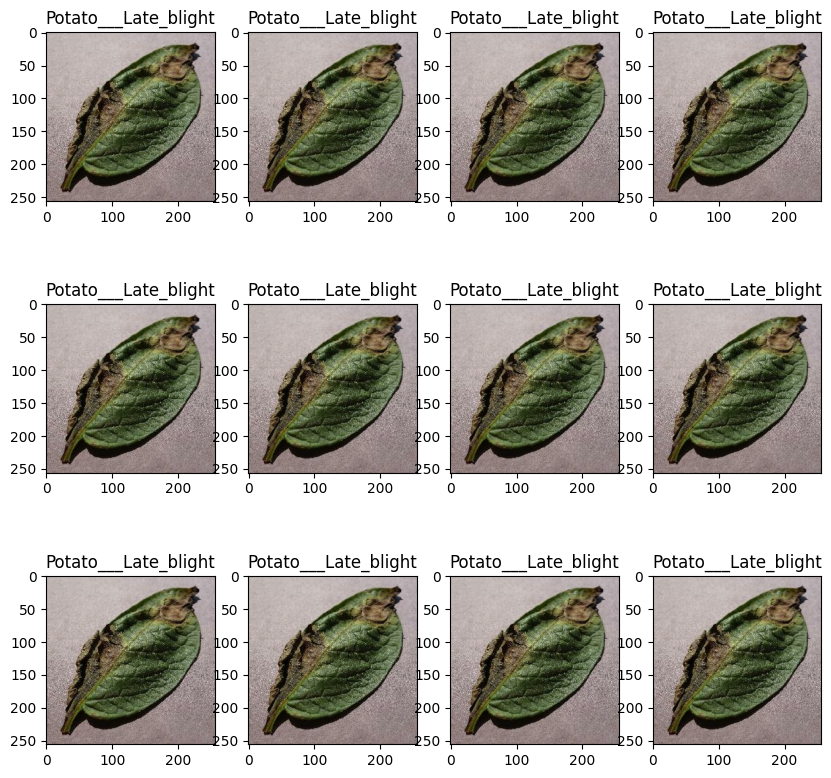

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):

  for i in range(12):
    plt.subplot(3,4,i+1)
    # print(image_batch.shape)
    # print(label_batch.numpy())
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])


In [ ]:
train=0.8
val=0.1
test=0.1
print(len(dataset)*train)

train_ds=dataset.take(54)


54.400000000000006


In [ ]:
print(len(train_ds))

test_ds=dataset.skip(54)
val_ds=test_ds.take(7)
test_ds=test_ds.skip(7)
print(len(test_ds))
print(len(val_ds))

54
7
7


In [ ]:
def getpartition(df,train_size=0.8,test_size=0.1,val_size=0.1,shuffle=True,shuffle_size=10000):
  df_size=len(df)
  if shuffle:
    df=df.shuffle(shuffle_size,seed=12)
  train_size=int(df_size*train_size)
  train_data=df.take(train_size)
  val_size=int(len(df)*val_size)
  val_data=df.skip(train_size).take(val_size)
  test_size=int(len(df)*test_size)
  test_data=df.skip(train_size).skip(val_size)
  return train_data,test_data,val_data

train_data,test_data,val_data=getpartition(dataset)

In [ ]:
print(len(train_data))
print(len(test_data))
print(len(val_data))

54
8
6


In [ ]:
train_ds=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(train_ds)

54

In [ ]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)

])

In [ ]:
from keras import activations
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_class=3
model= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_class,activation='softmax')

])
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
from tensorflow.python.training.saver import metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history= model.fit(
    train_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 353s 139ms/step - loss: 0.8022 - accuracy: 0.6615 - val_loss: 0.4740 - val_accuracy: 0.8385
Epoch 2/50
54/54 [==============================] - 3s 59ms/step - loss: 0.4461 - accuracy: 0.8287 - val_loss: 0.4076 - val_accuracy: 0.8333
Epoch 3/50
54/54 [==============================] - 3s 59ms/step - loss: 0.3422 - accuracy: 0.8623 - val_loss: 0.3032 - val_accuracy: 0.8906
Epoch 4/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2701 - accuracy: 0.8929 - val_loss: 0.1873 - val_accuracy: 0.9323
Epoch 5/50
54/54 [==============================] - 3s 59ms/step - loss: 0.2081 - accuracy: 0.9230 - val_loss: 0.3185 - val_accuracy: 0.8646
Epoch 6/50
54/54 [==============================] - 3s 59ms/step - loss: 0.2629 - accuracy: 0.9051 - val_loss: 0.2390 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 3s 61ms/step - loss: 0.1881 - accuracy: 0.9294 - val_loss: 0.3627 - val_accuracy: 0.8490
Epoch 8/50

In [ ]:
score=model.evaluate(test_data)

8/8 [==============================] - 5s 32ms/step - loss: 0.0693 - accuracy: 0.9805


In [ ]:
score

[0.06926818937063217, 0.98046875]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.6614583134651184,
 0.8287037014961243,
 0.8622685074806213,
 0.8929398059844971,
 0.9230324029922485,
 0.9050925970077515,
 0.9293981194496155,
 0.9375,
 0.9340277910232544,
 0.9565972089767456,
 0.9600694179534912,
 0.9409722089767456,
 0.9670138955116272,
 0.9641203880310059,
 0.9652777910232544,
 0.9554398059844971,
 0.9646990895271301,
 0.9658564925193787,
 0.9716435074806213,
 0.9606481194496155,
 0.9629629850387573,
 0.9768518805503845,
 0.9681712985038757,
 0.9751157164573669,
 0.9641203880310059,
 0.9629629850387573,
 0.9820601940155029,
 0.9693287014961243,
 0.9728009104728699,
 0.9780092835426331,
 0.9797453880310059,
 0.9664351940155029,
 0.9739583134651184,
 0.9623842835426331,
 0.9629629850387573,
 0.9739583134651184,
 0.9681712985038757,
 0.9855324029922485,
 0.9855324029922485,
 0.9635416865348816,
 0.9780092835426331,
 0.9895833134651184,
 0.96875,
 0.9872685074806213,
 0.9872685074806213,
 0.9878472089767456,
 0.9791666865348816,
 0.9809027910232544,
 0.984375,
 0.9

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']


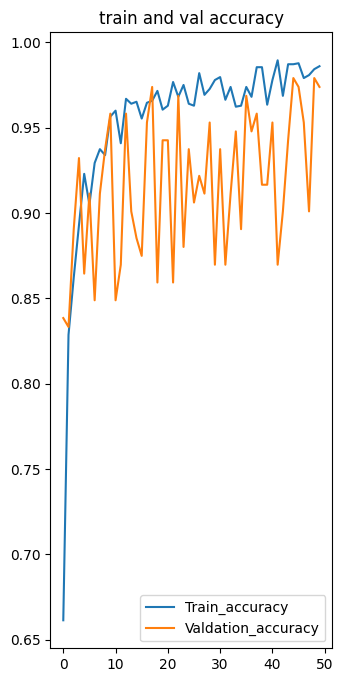

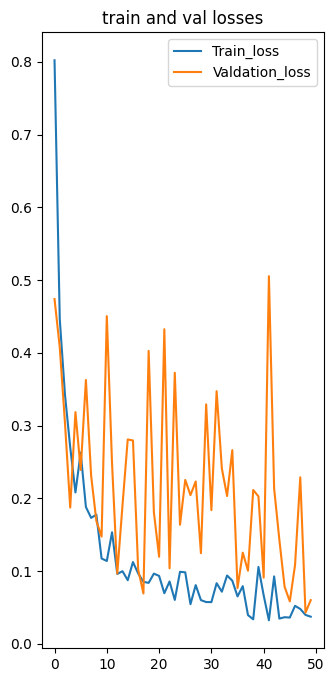

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCH),acc,label='Train_accuracy')
plt.plot(range(EPOCH),val_acc,label='Valdation_accuracy')
plt.legend(loc='lower right')
plt.title("train and val accuracy")


plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(EPOCH),loss,label='Train_loss')
plt.plot(range(EPOCH),val_loss,label='Valdation_loss')
plt.legend(loc='upper right')
plt.title("train and val losses")
plt.show()

first image to predict
first images actual label:  Potato___Late_blight
1/1 [==============================] - 0s 40ms/step
predicted label:  Potato___Late_blight


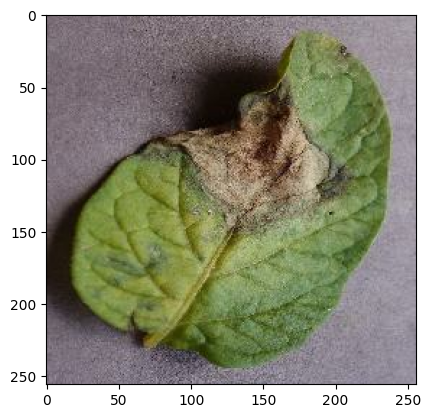

In [ ]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  first_label=label_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print("first images actual label: ",class_names[first_label])


  batch_prediction=model.predict(image_batch)
  print("predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


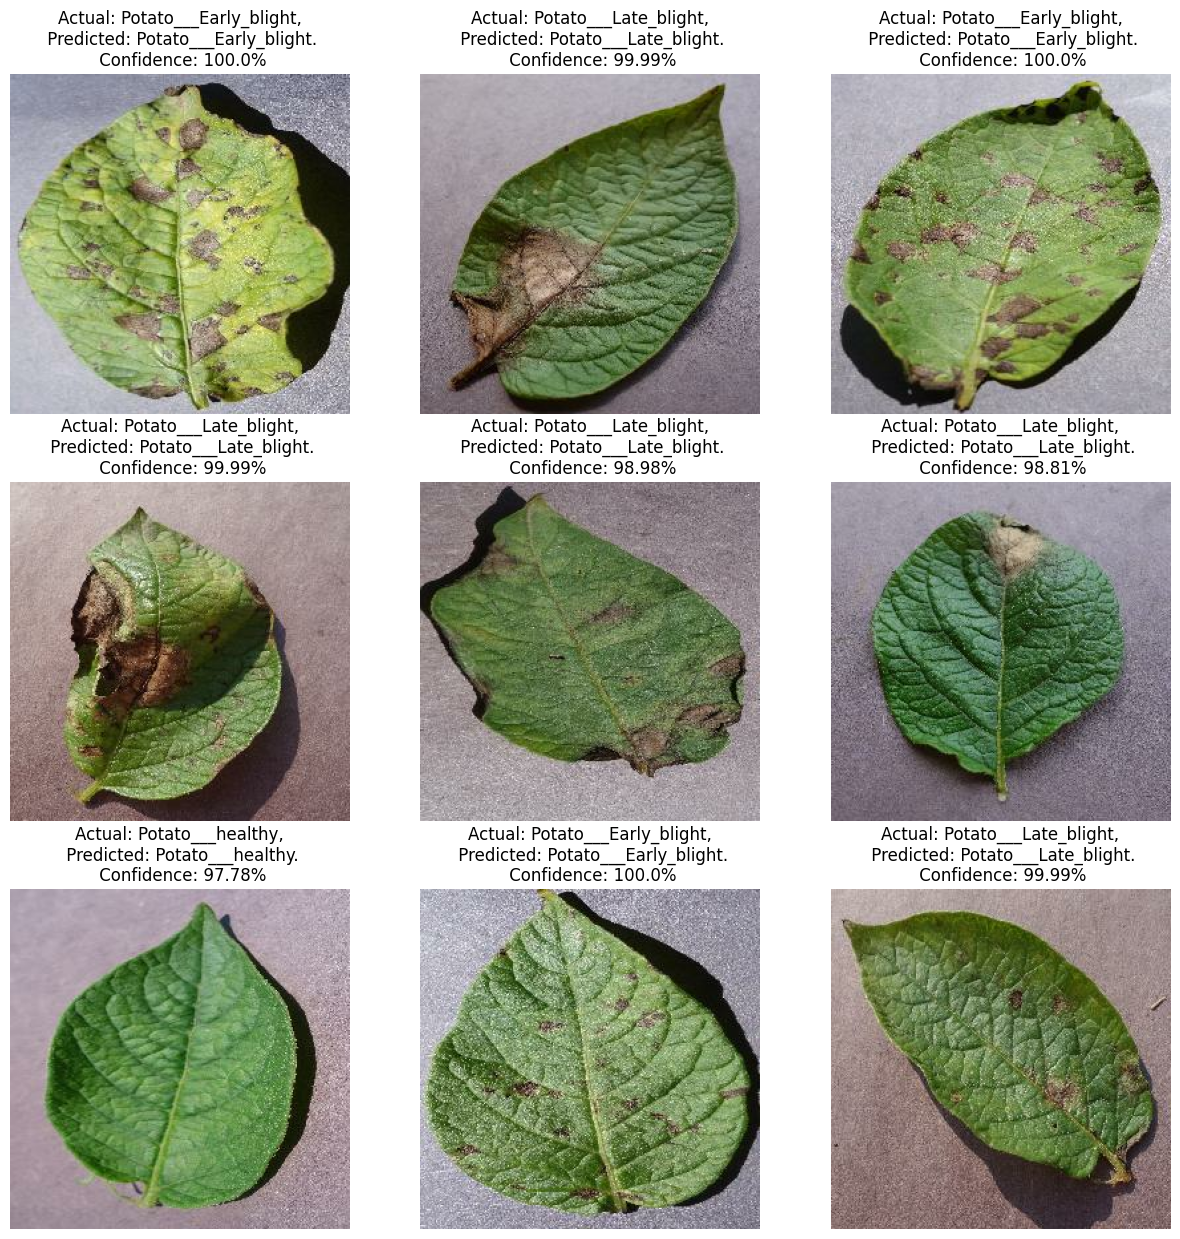

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
